## Import Libraries

In [73]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
import scipy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max
import random 
from tensorflow.keras.utils import plot_model
import visualkeras
import matplotlib.pyplot as plt

## Data Preprocessing

In [74]:
input_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset/')
output_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.2))

Copying files: 7261 files [00:11, 605.36 files/s]


In [75]:
train_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/train/')
val_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/val/')

In [76]:
def image_generator(train_parent_directory, val_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size=(224,224),
                                                        batch_size=140,
                                                        class_mode='categorical',
                                                        subset='training')
    
    val_generator = val_datagen.flow_from_directory(val_parent_directory,
                                                     target_size=(224,224),
                                                      batch_size=37,
                                                      class_mode='categorical')
    
    return train_generator, val_generator

In [77]:
train_generator, val_generator = image_generator(train_dir, val_dir)

Found 6591 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


## Data Exploration

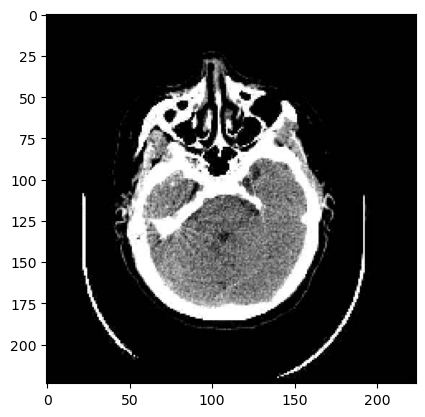

In [81]:
images, labels = next(train_generator)
image = images[0]

plt.imshow(image)
plt.show()

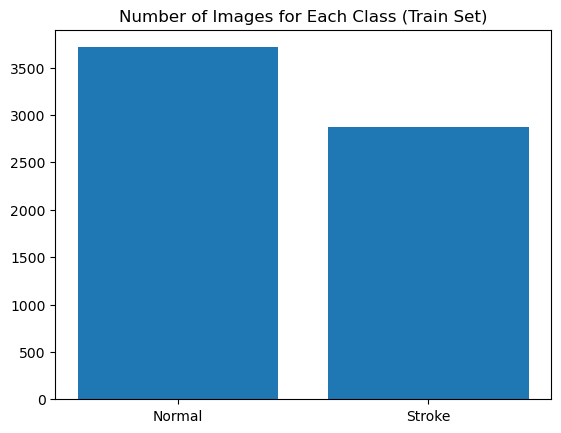

In [79]:
class_counts = train_generator.classes

img_list=[]

for i in class_counts:
    if i == 0:
        img_list.append('Normal')
    else:
        img_list.append('Stroke')
        
counts = dict()
for val in img_list:
    counts[val] = counts.get(val, 0) + 1

plt.bar(counts.keys(), counts.values())
plt.title('Number of Images for Each Class (Train Set)')
plt.show()

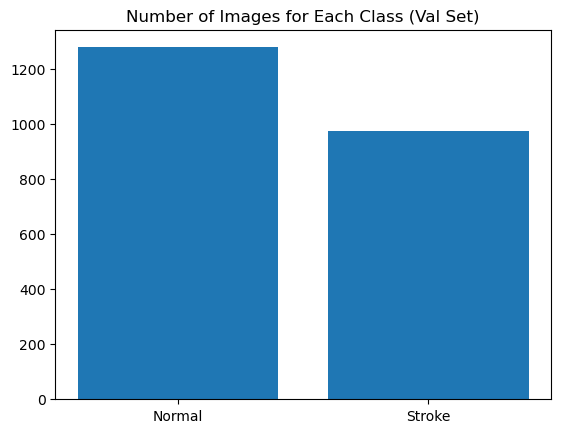

In [80]:
class_counts = val_generator.classes

img_list=[]

for i in class_counts:
    if i == 0:
        img_list.append('Normal')
    else:
        img_list.append('Stroke')
        
counts = dict()
for val in img_list:
    counts[val] = counts.get(val, 0) + 1

plt.bar(counts.keys(), counts.values())
plt.title('Number of Images for Each Class (Val Set)')
plt.show()

## Modelling

### Create Model

In [82]:
tfd = tfp.distributions
tfpl = tfp.layers

In [83]:
def create_bayesian_model(input_shape=(224, 224, 3), num_classes=2, divergence_fn=None):
    if divergence_fn is None:
        def divergence_fn(q, p, _):
            return tfp.distributions.kl_divergence(q, p) / 8569

    model = Sequential([
        tfpl.Convolution2DReparameterization(
            input_shape=input_shape, 
            filters=4, 
            kernel_size=8, 
            activation='relu',
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        tfpl.DenseReparameterization(
            units=tfpl.OneHotCategorical.params_size(num_classes), 
            activation=None,
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn=divergence_fn,
            bias_prior_fn=tfpl.default_multivariate_normal_fn,
            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn=divergence_fn
        ),
        tfpl.OneHotCategorical(num_classes)
    ])

    return model

In [84]:
model_bayes = create_bayesian_model(input_shape=(224, 224, 3), num_classes=2)

D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [85]:
model_bayes.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 217, 217, 4)      1544      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 108, 108, 4)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 51, 64)        18496     
                                                      

In [86]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

### Train and Validate Model

In [87]:
history_bayes = model_bayes.fit(
      train_generator,
      validation_data=val_generator,
      epochs=500,
      verbose=1)

Epoch 1/500
48/48 [==============================] - 162s 3s/step - loss: 1.2204 - accuracy: 0.5617 - val_loss: 1.0687 - val_accuracy: 0.6147
Epoch 2/500
48/48 [==============================] - 154s 3s/step - loss: 1.0414 - accuracy: 0.6459 - val_loss: 0.9703 - val_accuracy: 0.6636
Epoch 3/500
48/48 [==============================] - 153s 3s/step - loss: 0.9234 - accuracy: 0.7234 - val_loss: 0.8434 - val_accuracy: 0.7667
Epoch 4/500
48/48 [==============================] - 153s 3s/step - loss: 0.8132 - accuracy: 0.8011 - val_loss: 0.7829 - val_accuracy: 0.8249
Epoch 5/500
48/48 [==============================] - 153s 3s/step - loss: 0.7416 - accuracy: 0.8480 - val_loss: 0.7100 - val_accuracy: 0.8938
Epoch 6/500
48/48 [==============================] - 153s 3s/step - loss: 0.6774 - accuracy: 0.8935 - val_loss: 0.6385 - val_accuracy: 0.9147
Epoch 7/500
48/48 [==============================] - 153s 3s/step - loss: 0.6367 - accuracy: 0.9234 - val_loss: 0.6012 - val_accuracy: 0.9364
Epoch 

48/48 [==============================] - 154s 3s/step - loss: 0.5067 - accuracy: 0.9997 - val_loss: 0.5130 - val_accuracy: 0.9987
Epoch 59/500
48/48 [==============================] - 154s 3s/step - loss: 0.5060 - accuracy: 0.9998 - val_loss: 0.5136 - val_accuracy: 0.9982
Epoch 60/500
48/48 [==============================] - 154s 3s/step - loss: 0.5052 - accuracy: 0.9994 - val_loss: 0.5130 - val_accuracy: 0.9987
Epoch 61/500
48/48 [==============================] - 154s 3s/step - loss: 0.5048 - accuracy: 0.9995 - val_loss: 0.5134 - val_accuracy: 0.9982
Epoch 62/500
48/48 [==============================] - 153s 3s/step - loss: 0.5046 - accuracy: 0.9992 - val_loss: 0.5143 - val_accuracy: 0.9982
Epoch 63/500
48/48 [==============================] - 154s 3s/step - loss: 0.5041 - accuracy: 0.9994 - val_loss: 0.5097 - val_accuracy: 0.9991
Epoch 64/500
48/48 [==============================] - 154s 3s/step - loss: 0.5036 - accuracy: 0.9988 - val_loss: 0.5101 - val_accuracy: 0.9987
Epoch 65/500

48/48 [==============================] - 154s 3s/step - loss: 0.4665 - accuracy: 1.0000 - val_loss: 0.4757 - val_accuracy: 0.9987
Epoch 116/500
48/48 [==============================] - 154s 3s/step - loss: 0.4658 - accuracy: 0.9998 - val_loss: 0.4771 - val_accuracy: 0.9987
Epoch 117/500
48/48 [==============================] - 154s 3s/step - loss: 0.4654 - accuracy: 0.9998 - val_loss: 0.4774 - val_accuracy: 0.9987
Epoch 118/500
48/48 [==============================] - 154s 3s/step - loss: 0.4654 - accuracy: 0.9991 - val_loss: 0.4753 - val_accuracy: 0.9982
Epoch 119/500
48/48 [==============================] - 154s 3s/step - loss: 0.4668 - accuracy: 0.9976 - val_loss: 0.4684 - val_accuracy: 0.9991
Epoch 120/500
48/48 [==============================] - 154s 3s/step - loss: 0.4640 - accuracy: 0.9991 - val_loss: 0.4753 - val_accuracy: 0.9987
Epoch 121/500
48/48 [==============================] - 153s 3s/step - loss: 0.4636 - accuracy: 0.9988 - val_loss: 0.4721 - val_accuracy: 0.9987
Epoch 

Epoch 172/500
48/48 [==============================] - 154s 3s/step - loss: 0.4229 - accuracy: 0.9998 - val_loss: 0.4338 - val_accuracy: 0.9991
Epoch 173/500
48/48 [==============================] - 154s 3s/step - loss: 0.4220 - accuracy: 1.0000 - val_loss: 0.4334 - val_accuracy: 0.9987
Epoch 174/500
48/48 [==============================] - 154s 3s/step - loss: 0.4212 - accuracy: 1.0000 - val_loss: 0.4298 - val_accuracy: 0.9987
Epoch 175/500
48/48 [==============================] - 154s 3s/step - loss: 0.4205 - accuracy: 0.9998 - val_loss: 0.4276 - val_accuracy: 0.9991
Epoch 176/500
48/48 [==============================] - 154s 3s/step - loss: 0.4197 - accuracy: 1.0000 - val_loss: 0.4283 - val_accuracy: 0.9987
Epoch 177/500
48/48 [==============================] - 157s 3s/step - loss: 0.4188 - accuracy: 0.9998 - val_loss: 0.4311 - val_accuracy: 0.9987
Epoch 178/500
48/48 [==============================] - 157s 3s/step - loss: 0.4180 - accuracy: 0.9997 - val_loss: 0.4290 - val_accuracy:

Epoch 229/500
48/48 [==============================] - 153s 3s/step - loss: 0.3798 - accuracy: 0.9997 - val_loss: 0.3964 - val_accuracy: 0.9987
Epoch 230/500
48/48 [==============================] - 153s 3s/step - loss: 0.3791 - accuracy: 0.9991 - val_loss: 0.3974 - val_accuracy: 0.9987
Epoch 231/500
48/48 [==============================] - 153s 3s/step - loss: 0.3798 - accuracy: 0.9988 - val_loss: 0.3895 - val_accuracy: 0.9978
Epoch 232/500
48/48 [==============================] - 154s 3s/step - loss: 0.3776 - accuracy: 0.9994 - val_loss: 0.3867 - val_accuracy: 0.9991
Epoch 233/500
48/48 [==============================] - 154s 3s/step - loss: 0.3770 - accuracy: 0.9994 - val_loss: 0.3838 - val_accuracy: 0.9987
Epoch 234/500
48/48 [==============================] - 153s 3s/step - loss: 0.3755 - accuracy: 0.9997 - val_loss: 0.3884 - val_accuracy: 0.9987
Epoch 235/500
48/48 [==============================] - 154s 3s/step - loss: 0.3749 - accuracy: 1.0000 - val_loss: 0.3788 - val_accuracy:

Epoch 286/500
48/48 [==============================] - 153s 3s/step - loss: 0.3389 - accuracy: 0.9989 - val_loss: 0.3445 - val_accuracy: 0.9982
Epoch 287/500
48/48 [==============================] - 153s 3s/step - loss: 0.3370 - accuracy: 0.9997 - val_loss: 0.3459 - val_accuracy: 0.9987
Epoch 288/500
48/48 [==============================] - 153s 3s/step - loss: 0.3352 - accuracy: 0.9997 - val_loss: 0.3435 - val_accuracy: 0.9987
Epoch 289/500
48/48 [==============================] - 153s 3s/step - loss: 0.3399 - accuracy: 0.9979 - val_loss: 0.3427 - val_accuracy: 0.9987
Epoch 290/500
48/48 [==============================] - 153s 3s/step - loss: 0.3366 - accuracy: 0.9986 - val_loss: 0.3409 - val_accuracy: 0.9987
Epoch 291/500
48/48 [==============================] - 153s 3s/step - loss: 0.3334 - accuracy: 0.9994 - val_loss: 0.3438 - val_accuracy: 0.9982
Epoch 292/500
48/48 [==============================] - 153s 3s/step - loss: 0.3333 - accuracy: 0.9995 - val_loss: 0.3464 - val_accuracy:

Epoch 343/500
48/48 [==============================] - 153s 3s/step - loss: 0.2975 - accuracy: 1.0000 - val_loss: 0.3083 - val_accuracy: 0.9987
Epoch 344/500
48/48 [==============================] - 153s 3s/step - loss: 0.2969 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9987
Epoch 345/500
48/48 [==============================] - 153s 3s/step - loss: 0.2962 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9987
Epoch 346/500
48/48 [==============================] - 153s 3s/step - loss: 0.2956 - accuracy: 0.9998 - val_loss: 0.3009 - val_accuracy: 0.9987
Epoch 347/500
48/48 [==============================] - 153s 3s/step - loss: 0.2949 - accuracy: 1.0000 - val_loss: 0.3021 - val_accuracy: 0.9991
Epoch 348/500
48/48 [==============================] - 154s 3s/step - loss: 0.2950 - accuracy: 0.9997 - val_loss: 0.3033 - val_accuracy: 0.9991
Epoch 349/500
48/48 [==============================] - 153s 3s/step - loss: 0.2943 - accuracy: 0.9992 - val_loss: 0.3006 - val_accuracy:

Epoch 400/500
48/48 [==============================] - 153s 3s/step - loss: 0.2606 - accuracy: 0.9998 - val_loss: 0.2774 - val_accuracy: 0.9991
Epoch 401/500
48/48 [==============================] - 153s 3s/step - loss: 0.2598 - accuracy: 0.9997 - val_loss: 0.2764 - val_accuracy: 0.9987
Epoch 402/500
48/48 [==============================] - 153s 3s/step - loss: 0.2591 - accuracy: 1.0000 - val_loss: 0.2850 - val_accuracy: 0.9991
Epoch 403/500
48/48 [==============================] - 152s 3s/step - loss: 0.2584 - accuracy: 1.0000 - val_loss: 0.2789 - val_accuracy: 0.9987
Epoch 404/500
48/48 [==============================] - 153s 3s/step - loss: 0.2577 - accuracy: 1.0000 - val_loss: 0.2812 - val_accuracy: 0.9987
Epoch 405/500
48/48 [==============================] - 152s 3s/step - loss: 0.2570 - accuracy: 0.9998 - val_loss: 0.2774 - val_accuracy: 0.9987
Epoch 406/500
48/48 [==============================] - 153s 3s/step - loss: 0.2563 - accuracy: 0.9998 - val_loss: 0.2859 - val_accuracy:

Epoch 457/500
48/48 [==============================] - 153s 3s/step - loss: 0.2331 - accuracy: 0.9997 - val_loss: 0.2431 - val_accuracy: 0.9991
Epoch 458/500
48/48 [==============================] - 153s 3s/step - loss: 0.2328 - accuracy: 0.9997 - val_loss: 0.2498 - val_accuracy: 0.9991
Epoch 459/500
48/48 [==============================] - 153s 3s/step - loss: 0.2323 - accuracy: 0.9995 - val_loss: 0.2435 - val_accuracy: 0.9991
Epoch 460/500
48/48 [==============================] - 153s 3s/step - loss: 0.2311 - accuracy: 0.9998 - val_loss: 0.2431 - val_accuracy: 0.9991
Epoch 461/500
48/48 [==============================] - 152s 3s/step - loss: 0.2303 - accuracy: 0.9998 - val_loss: 0.2471 - val_accuracy: 0.9987
Epoch 462/500
48/48 [==============================] - 152s 3s/step - loss: 0.2298 - accuracy: 1.0000 - val_loss: 0.2438 - val_accuracy: 0.9991
Epoch 463/500
48/48 [==============================] - 152s 3s/step - loss: 0.2369 - accuracy: 0.9971 - val_loss: 0.2367 - val_accuracy:

### Evaluate Model

In [88]:
_,train_acc = model_bayes.evaluate(train_generator)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model_bayes.evaluate(val_generator)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

48/48 [==============================] - 31s 646ms/step - loss: 0.2116 - accuracy: 1.0000
Accuracy of train datasets =  100.0 %
61/61 [==============================] - 11s 173ms/step - loss: 0.2305 - accuracy: 0.9991
Accuracy of valid datasets =  99.91111159324646 %


206/206 [==============================] - 21s 94ms/step


Text(0.5, 1.0, 'Confusion Matrix (Train Set)')

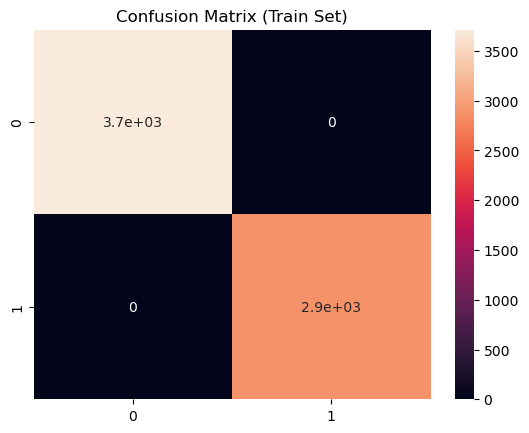

In [89]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Dataset2/train/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Dataset2/train/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/train/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/train/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

X_test = dataset
y_test = label
X_test = X_test/255.
y_test = to_categorical(y_test)

y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix (Train Set)')

In [90]:
precision = cm[0,0] / (cm[0,0] + cm[0,1])
recall = cm[0,0] / (cm[0,0] + cm[1,0])
specificity = cm[1,1] / (cm[1,1] + cm[0,1])
f1_score = 2 * precision * recall / (precision + recall)

print("Precision on train set:", precision)
print("Recall on train set:", recall)
print("Specitivity on train set:", specificity)
print("F1 Score on train set:", f1_score)

Precision on train set: 1.0
Recall on train set: 1.0
Specitivity on train set: 1.0
F1 Score on train set: 1.0


71/71 [==============================] - 7s 91ms/step


Text(0.5, 1.0, 'Confusion Matrix (Val Set)')

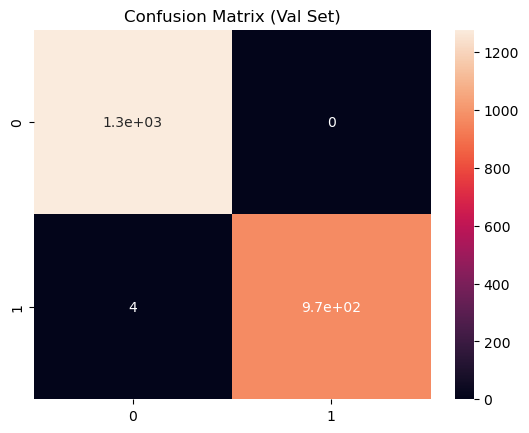

In [91]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Dataset2/val/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Dataset2/val/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/val/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/val/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

X_test = dataset
y_test = label
X_test = X_test/255.
y_test = to_categorical(y_test)

y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix (Val Set)')

In [92]:
precision = cm[0,0] / (cm[0,0] + cm[0,1])
recall = cm[0,0] / (cm[0,0] + cm[1,0])
specificity = cm[1,1] / (cm[1,1] + cm[0,1])
f1_score = 2 * precision * recall / (precision + recall)

print("Precision on val set:", precision)
print("Recall on val set:", recall)
print("Specitivity on val set:", specificity)
print("F1 Score on val set:", f1_score)

Precision on val set: 1.0
Recall on val set: 0.9968774395003903
Specitivity on val set: 1.0
F1 Score on val set: 0.9984362783424551


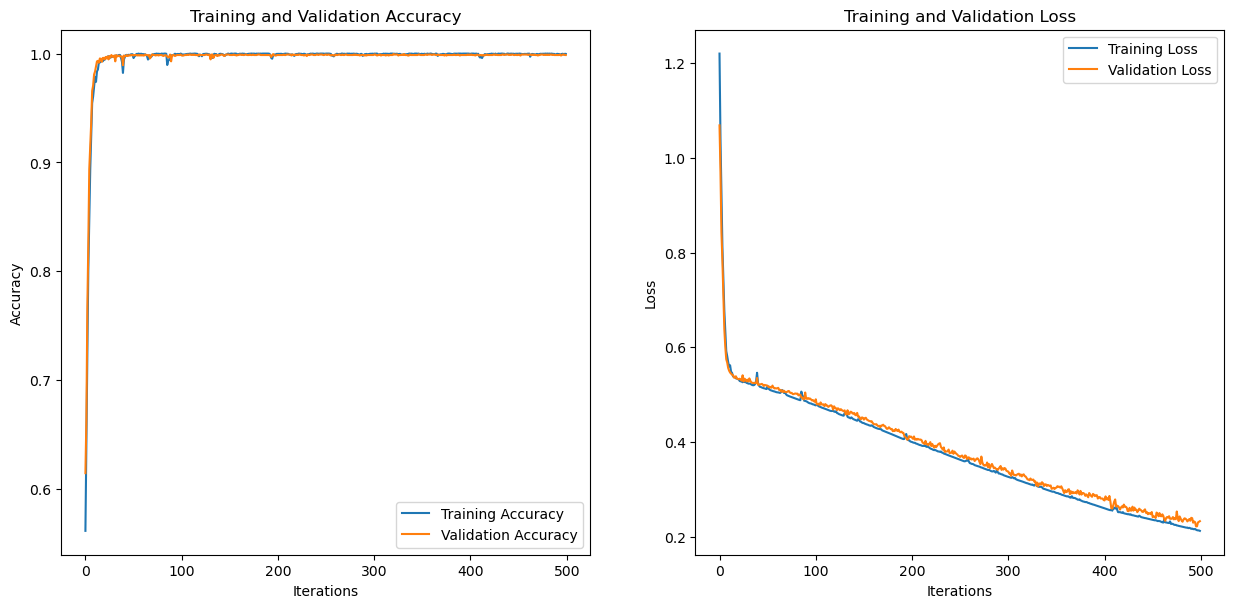

In [93]:
acc = history_bayes.history['accuracy']
val_acc = history_bayes.history['val_accuracy']
loss = history_bayes.history['loss']
val_loss = history_bayes.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

The final train value of J is  0.2122202217578888


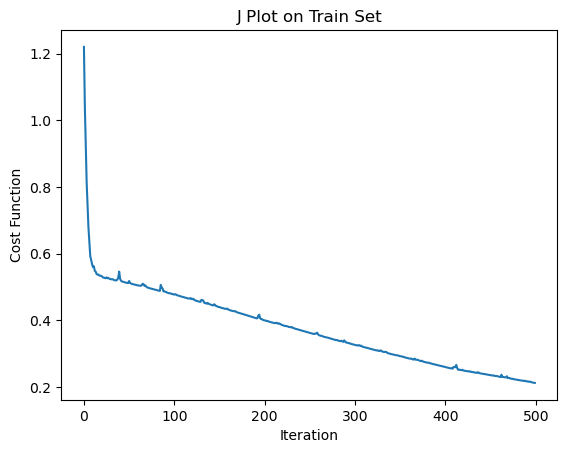

In [94]:
J = history_bayes.history['loss']
plt.plot(J)
plt.title('J Plot on Train Set')
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
print('The final train value of J is ', J[500-1])

The final train value of J is  0.2326737493276596


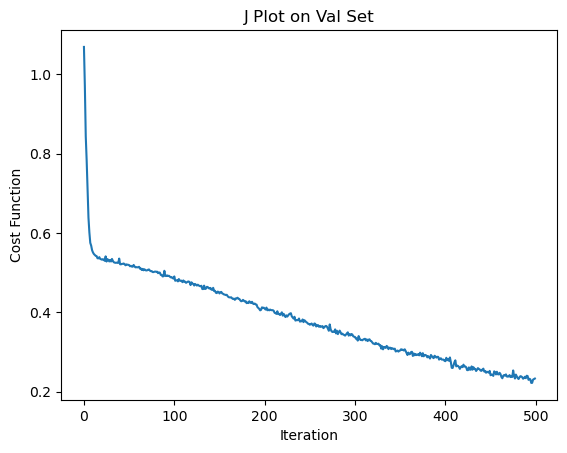

In [95]:
J = history_bayes.history['val_loss']
plt.plot(J)
plt.title('J Plot on Val Set')
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
print('The final train value of J is ', J[500-1])

### Predict

In [106]:
size = 224
dataset = []
label = []

stroke_images = os.listdir('Dataset2/test/Stroke/')
for i, image_name in enumerate(stroke_images):
    image = cv2.imread('Dataset2/test/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/test/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/test/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [107]:
X_test = dataset
y_test = label

In [108]:
X_test = X_test/255.
y_test = to_categorical(y_test)

In [109]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.5, # Randomly zoom image 
        width_shift_range=0.6,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.6,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_test)

2/2 [==============================] - 0s 87ms/step


Text(0.5, 1.0, 'Confusion matrix (Test Set)')

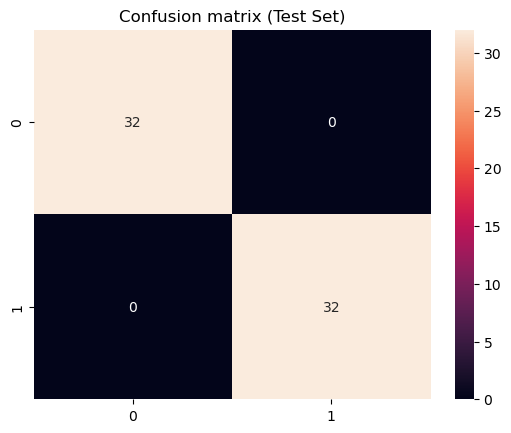

In [110]:
y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix (Test Set)')

In [101]:
precision = cm[0,0] / (cm[0,0] + cm[0,1])
recall = cm[0,0] / (cm[0,0] + cm[1,0])
specificity = cm[1,1] / (cm[1,1] + cm[0,1])
f1_score = 2 * precision * recall / (precision + recall)

print("Precision on test set:", precision)
print("Recall on test set:", recall)
print("Specitivity on test set:", specificity)
print("F1 Score on test set:", f1_score)

Precision on test set: 1.0
Recall on test set: 1.0
Specitivity on test set: 1.0
F1 Score on test set: 1.0


## Save Model

In [102]:
model_bayes.save("bayesian_model")
model = tf.saved_model.load("bayesian_model")

INFO:tensorflow:Assets written to: bayesian_model\assets


INFO:tensorflow:Assets written to: bayesian_model\assets


## Load Saved Model

In [103]:
loaded_model = tf.keras.models.load_model("bayesian_model", compile=False)
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 217, 217, 4)      1544      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 108, 108, 4)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 51, 64)        18496     
                                                      

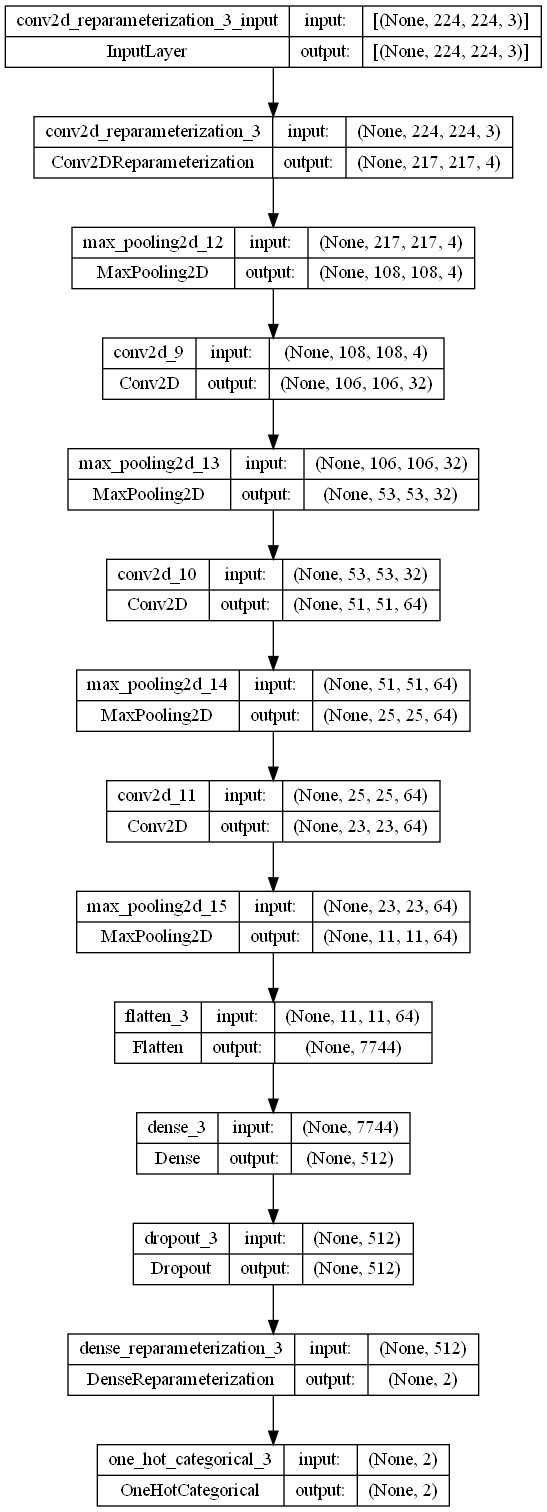

In [213]:
plot_model(loaded_model, to_file='bayesian_model_plot.png', show_shapes=True, show_layer_names=True)

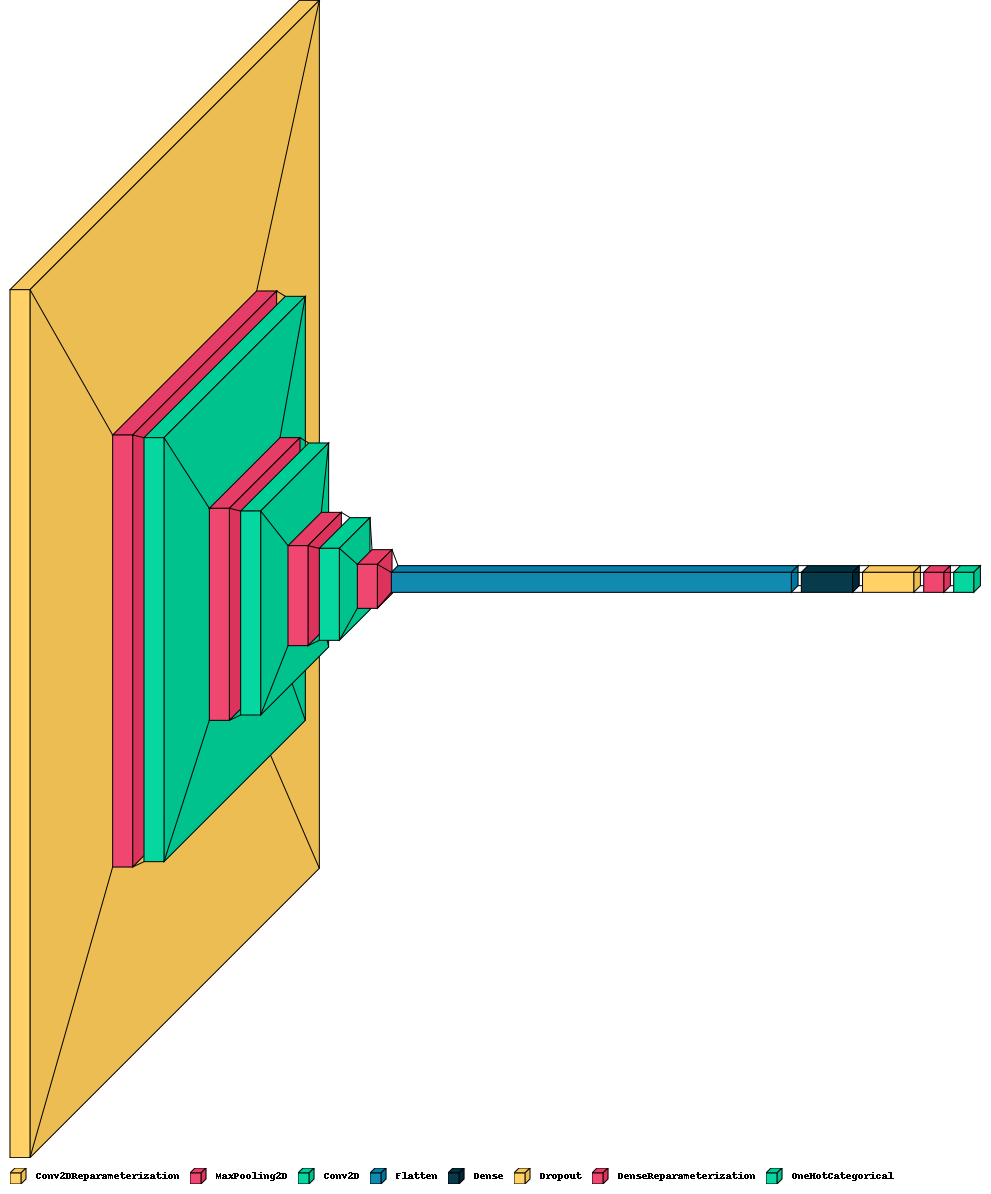

In [214]:
visualkeras.layered_view(loaded_model, legend=True) 

## Detect Anormalies

In [134]:
# stroke_image_list = []
# stroke_images = os.listdir('Dataset2/val/Stroke/')
# for i, image_name in enumerate(stroke_images):
#     image = cv2.imread('Dataset2/val/Stroke/' + image_name)
#     image = Image.fromarray(image)
#     image = image.resize((size,size))
#     stroke_image_list.append(np.array(image))

# pneumothorax_images_idx = np.where(y_pred == 1)[0]
# predicted_as_para = []
# for i in pneumothorax_images_idx:
#     pneu_img = X_test[i]
#     predicted_as_para.append(pneu_img)
    
# predicted_as_para = np.array(predicted_as_para)

In [25]:
# def plot_heatmap(img, model):
#     pred = model.predict(np.expand_dims(img, axis=0))
#     pred_class = np.argmax(pred)
#     last_layer_weights = model.layers[-1].get_weights()[0]
#     last_layer_weights_for_pred = last_layer_weights[:, pred_class]
#     last_conv_model = Model(model.input, model.get_layer("max_pooling2d_11").output)
#     last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
#     last_conv_output = np.squeeze(last_conv_output)
    
#     h = int(img.shape[0]/last_conv_output.shape[0])
#     w = int(img.shape[1]/last_conv_output.shape[1])
#     upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
#     heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 64)), 
#                  last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
#     heat_map[img[:,:,0] == 0] = 0 
     
#     peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

#     plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
#     plt.imshow(heat_map, cmap='jet', alpha=0.30)
#     for i in range(0,peak_coords.shape[0]):
#         print(i)
#         y = peak_coords[i,0]
#         x = peak_coords[i,1]
#         plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


In [26]:
# image = random.randint(0,predicted_as_para.shape[0]-1)
# heat_map = plot_heatmap(predicted_as_para[image], model_bayes)

# img = predicted_as_para[image]
# plt.imshow(predicted_as_para[img])

In [4]:
# Load and preprocess the image
img = cv2.imread('Prediction/Stroke/58 (3).jpg')
img = cv2.resize(img, (224, 224)) / 255.0
img = np.expand_dims(img, axis=0)

# Get the predicted class probabilities
probs = loaded_model.predict(img)[0]
print(probs)
# Threshold the probabilities to obtain a binary mask
mask = np.zeros_like(probs)
mask[np.argmax(probs)] = 1

# Extract the bounding box from the binary mask
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    x, y, w, h = cv2.boundingRect(contours[0])
    # Draw the bounding box on the original image
    cv2.rectangle(img[0], (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with the bounding box
cv2.imshow('image', img[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step
[0. 1.]
